In [ ]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent  
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")


In [ ]:
from hydro_forecasting.data.data_lazy_processor import Caravanify, CaravanifyConfig
from hydro_forecasting.data.preprocessing import check_data_quality



---

In [14]:
config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/timeseries/csv",
    gauge_id_prefix="CL",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

In [19]:
caravan = Caravanify(config)
ids_for_training = caravan.get_all_gauge_ids()

caravan.load_stations(ids_for_training)
ts_data = caravan.get_time_series()

ts_data

,gauge_id,date,dewpoint_temperature_2m_max,dewpoint_temperature_2m_mean,dewpoint_temperature_2m_min,potential_evaporation_sum_ERA5_LAND,potential_evaporation_sum_FAO_PENMAN_MONTEITH,snow_depth_water_equivalent_max,snow_depth_water_equivalent_mean,snow_depth_water_equivalent_min,...,volumetric_soil_water_layer_1_min,volumetric_soil_water_layer_2_max,volumetric_soil_water_layer_2_mean,volumetric_soil_water_layer_2_min,volumetric_soil_water_layer_3_max,volumetric_soil_water_layer_3_mean,volumetric_soil_water_layer_3_min,volumetric_soil_water_layer_4_max,volumetric_soil_water_layer_4_mean,volumetric_soil_water_layer_4_min
0,CL_1001001,1951-01-01,5.65,1.73,0.29,4.29,3.18,6.16,1.79,0.37,...,0.38,0.38,0.36,0.34,0.35,0.35,0.35,0.34,0.34,0.34
1,CL_1001001,1951-01-02,3.80,0.19,-2.03,3.06,2.28,8.09,5.20,2.84,...,0.40,0.41,0.40,0.39,0.36,0.35,0.35,0.34,0.34,0.34
2,CL_1001001,1951-01-03,0.39,-2.06,-5.11,2.30,1.36,5.68,4.13,3.01,...,0.40,0.41,0.40,0.40,0.36,0.36,0.36,0.34,0.34,0.34
3,CL_1001001,1951-01-04,-0.31,-3.51,-7.89,4.58,2.86,5.70,3.80,1.78,...,0.40,0.40,0.40,0.40,0.36,0.36,0.36,0.34,0.34,0.34
4,CL_1001001,1951-01-05,-0.45,-4.06,-8.60,5.51,3.18,1.80,1.16,0.49,...,0.38,0.40,0.39,0.39,0.36,0.36,0.36,0.34,0.34,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464305,CL_9437002,2023-12-26,17.38,12.23,8.13,13.39,5.90,0.06,0.05,0.03,...,0.24,0.28,0.27,0.27,0.30,0.29,0.29,0.40,0.40,0.40
13464306,CL_9437002,2023-12-27,14.84,13.21,11.35,11.24,5.27,0.03,0.02,0.01,...,0.23,0.27,0.27,0.26,0.29,0.29,0.29,0.40,0.40,0.40
13464307,CL_9437002,2023-12-28,11.61,10.98,10.32,9.18,4.16,0.01,0.01,0.01,...,0.22,0.26,0.26,0.26,0.29,0.29,0.29,0.40,0.40,0.40
13464308,CL_9437002,2023-12-29,11.42,10.35,8.75,13.22,5.68,0.01,0.00,0.00,...,0.22,0.26,0.25,0.25,0.29,0.29,0.28,0.40,0.40,0.40


In [20]:
quality_check_result = check_data_quality(
    df=ts_data,
    required_columns=["date", "streamflow", "total_precipitation_sum"],
    max_missing_pct=5,
    max_gap_length=30,
    min_train_years=5,
    max_imputation_gap_size=5,
    group_identifier="gauge_id",
    train_prop=0.7,
    val_prop=0.15,
    test_prop=0.15,
)

valid_data, quality_report = quality_check_result.unwrap()

<Axes: >

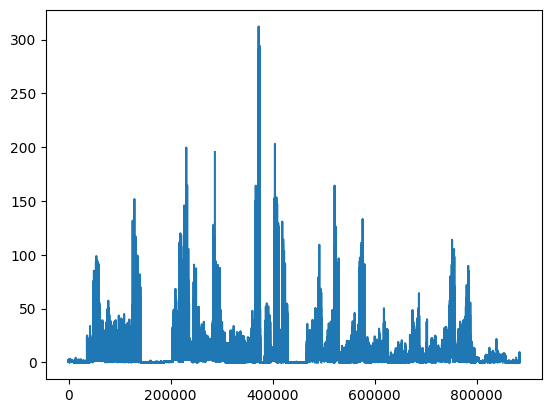

In [17]:
valid_data["streamflow"].plot()

In [18]:
quality_report

{'original_basins': 100,
 'retained_basins': 94,
 'excluded_basins': {'CL_10405001': 'Insufficient training period (3.67 years, minimum 5 required). Need 7.14 total years with current proportions.',
  'CL_11151001': 'Insufficient training period (2.01 years, minimum 5 required). Need 7.14 total years with current proportions.',
  'CL_11314001': 'Insufficient training period (4.47 years, minimum 5 required). Need 7.14 total years with current proportions.',
  'CL_11500002': 'Insufficient training period (4.49 years, minimum 5 required). Need 7.14 total years with current proportions.',
  'CL_11504001': 'Insufficient training period (4.35 years, minimum 5 required). Need 7.14 total years with current proportions.',
  'CL_11532000': 'Insufficient training period (4.27 years, minimum 5 required). Need 7.14 total years with current proportions.'},
 'basins': {'CL_1001001': {'valid_period': {'date': {'start': Timestamp('1951-01-01 00:00:00'),
     'end': Timestamp('2023-12-30 00:00:00')},
  